# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
### Input*Gradient Code by: Antonios Mamalakis
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

### Load Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install cartopy

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import scipy

import tensorflow as tf

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.1 MB/s eta 0:00:00


### Input*Gradient Function

In [2]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)

        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)

        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(preds, inputs) # d(preds)/d(inputs)
    return grads

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

In [3]:
# ---- OPEN dataset ----
path = '/content/drive/My Drive/OtherPresentations/Lectures/OA2024_CUBoulder/'
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'

sstds = xr.open_dataset(path+filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True) # select the tropics
lat = np.asarray(sst.lat) #latitude array
lon = np.asarray(sst.lon) #longitude array
time = sstds.time # time array

# ---- CALCULATE nino3.4 index (output) ----
# Define the nino3.4 box (5S-5N, 190E-240E)
LAT_S, LAT_N = -5, 5
LON_W, LON_E = 190, 240
# select nino3.4 box and convert xarray into a numpy array
sstnino = np.asarray(sst.sel(lat=slice(LAT_S,LAT_N),lon=slice(LON_W,LON_E)))
# take mean over nino3.4 box (this is our index)
nino34 = np.nanmean(sstnino,axis=(1,2))

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [4]:
# ---- FIND El Nino and La Nina events ----
nino_magnitude = 0.5

nino_occur = nino34[(nino34>nino_magnitude) | (nino34<(-1*nino_magnitude))] # only samples where nino event occurs
nino_occur[nino_occur>nino_magnitude] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<nino_magnitude] = 0

nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

# ---- PREPARE input (SST) and output (El Nino/La Nina) ----
train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst) # convert xarray to numpy
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# ---- SPLIT into training, validation, and testing ----
# input
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

# output
nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

In [5]:
# ---- STANDARDIZE our input ----
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD (mean has already been removed)

sst_train = np.divide(sst_train,sst_std)
sst_val = np.divide(sst_val,sst_std)
sst_test = np.divide(sst_test,sst_std)

sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val[np.isnan(sst_val)] = 0
sst_test[np.isnan(sst_test)] = 0

## Load Trained Neural Network

In [6]:
model = tf.keras.models.load_model(path+'saved_model/ENSOmodel.h5')

## Plot SST composites of correct predictions
How does the model do on unseen data?

In [7]:
# ---- PREDICT using your testing data ----
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

# find where the model is correct
modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

3/3 [==============================] - 0s 4ms/step
Model accuracy on testing is 100.000000%


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


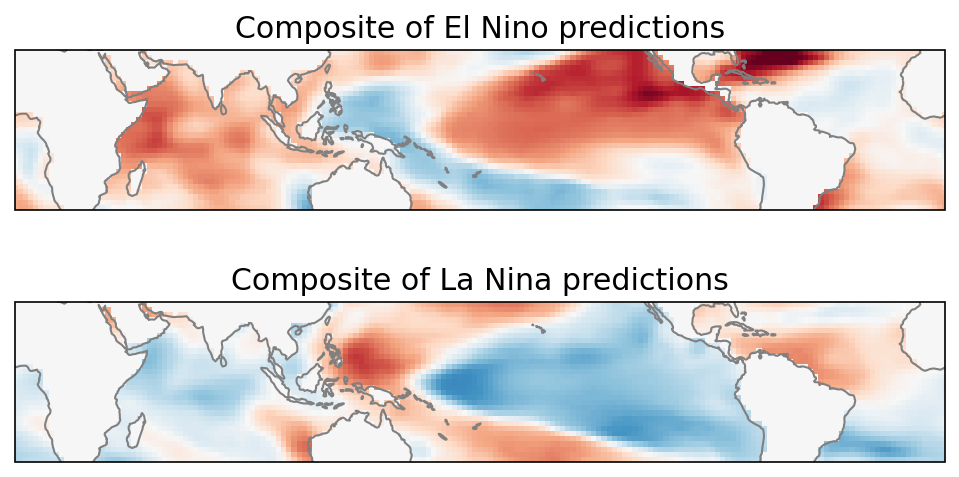

In [8]:
# ---- PLOT composites of the SST inputs ----
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

# grab input sst that led to an el nino prediction
elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
# grad input sst that led to a la nina prediction
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))
# take the mean of those samples
elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

# ---- PLOT the SSTs that led to an El Nino or La Nina ----
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Input * Gradient

In [9]:
# Calculate Input*Gradient for correct predictions in each class
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

# find where NN is correct
icorr = nino_pred==nino_true
nino_true_corr = nino_true[icorr]
nino_pred_corr = nino_pred[icorr]

# split correct predictions into each class (0=la nina, 1=el nino)
ilanina_corr = (nino_pred_corr==0)
ielnino_corr = (nino_pred_corr==1)

# grab SST input associated with the correct, class-dependent output
sst_lanina_corr = sst_test[icorr][ilanina_corr]
sst_elnino_corr = sst_test[icorr][ielnino_corr]

# calculate input*gradient (ItG)
## arrays of ItG maps
lanina_ItG_heatmap = np.zeros(shape = (np.shape(sst_lanina_corr)[0],sst_test.shape[-1]))
elnino_ItG_heatmap = np.zeros(shape = (np.shape(sst_elnino_corr)[0],sst_test.shape[-1]))

## arrays of gradient maps
lanina_Grad_heatmap = np.zeros(shape = (np.shape(sst_lanina_corr)[0],sst_test.shape[-1]))
elnino_Grad_heatmap = np.zeros(shape = (np.shape(sst_elnino_corr)[0],sst_test.shape[-1]))

for s,sample in enumerate(sst_lanina_corr):
    lanina_Grad_heatmap[s] = get_gradients((sample.reshape((1,sst_test.shape[-1]))),top_pred_idx=0).numpy()
    lanina_ItG_heatmap[s] = np.multiply(lanina_Grad_heatmap[s],sample.reshape((1,sst_test.shape[-1])))

for s,sample in enumerate(sst_elnino_corr):
    elnino_Grad_heatmap[s] = get_gradients((sample.reshape((1,sst_test.shape[-1]))),top_pred_idx=1).numpy()
    elnino_ItG_heatmap[s] = np.multiply(elnino_Grad_heatmap[s],sample.reshape((1,sst_test.shape[-1])))

3/3 [==============================] - 0s 3ms/step


In [10]:
# calculate mean across samples:
lanina_Input_mean = np.reshape(np.mean(sst_lanina_corr,axis=0),(sizesst[1],sizesst[2]))
elnino_Input_mean = np.reshape(np.mean(sst_elnino_corr,axis=0),(sizesst[1],sizesst[2]))

lanina_Grad_meanheatmap = np.reshape(np.mean(lanina_Grad_heatmap,axis=0),(sizesst[1],sizesst[2]))
elnino_Grad_meanheatmap = np.reshape(np.mean(elnino_Grad_heatmap,axis=0),(sizesst[1],sizesst[2]))

lanina_ItG_meanheatmap = np.reshape(np.mean(lanina_ItG_heatmap,axis=0),(sizesst[1],sizesst[2]))
elnino_ItG_meanheatmap = np.reshape(np.mean(elnino_ItG_heatmap,axis=0),(sizesst[1],sizesst[2]))

In [11]:
# smooth gradient to make plot prettier
lanina_Grad_meanheatmap = scipy.ndimage.gaussian_filter(lanina_Grad_meanheatmap, sigma=0.7)
elnino_Grad_meanheatmap = scipy.ndimage.gaussian_filter(elnino_Grad_meanheatmap, sigma=0.7)

lanina_ItG_meanheatmap = scipy.ndimage.gaussian_filter(lanina_ItG_meanheatmap, sigma=0.7)
elnino_ItG_meanheatmap = scipy.ndimage.gaussian_filter(elnino_ItG_meanheatmap, sigma=0.7)

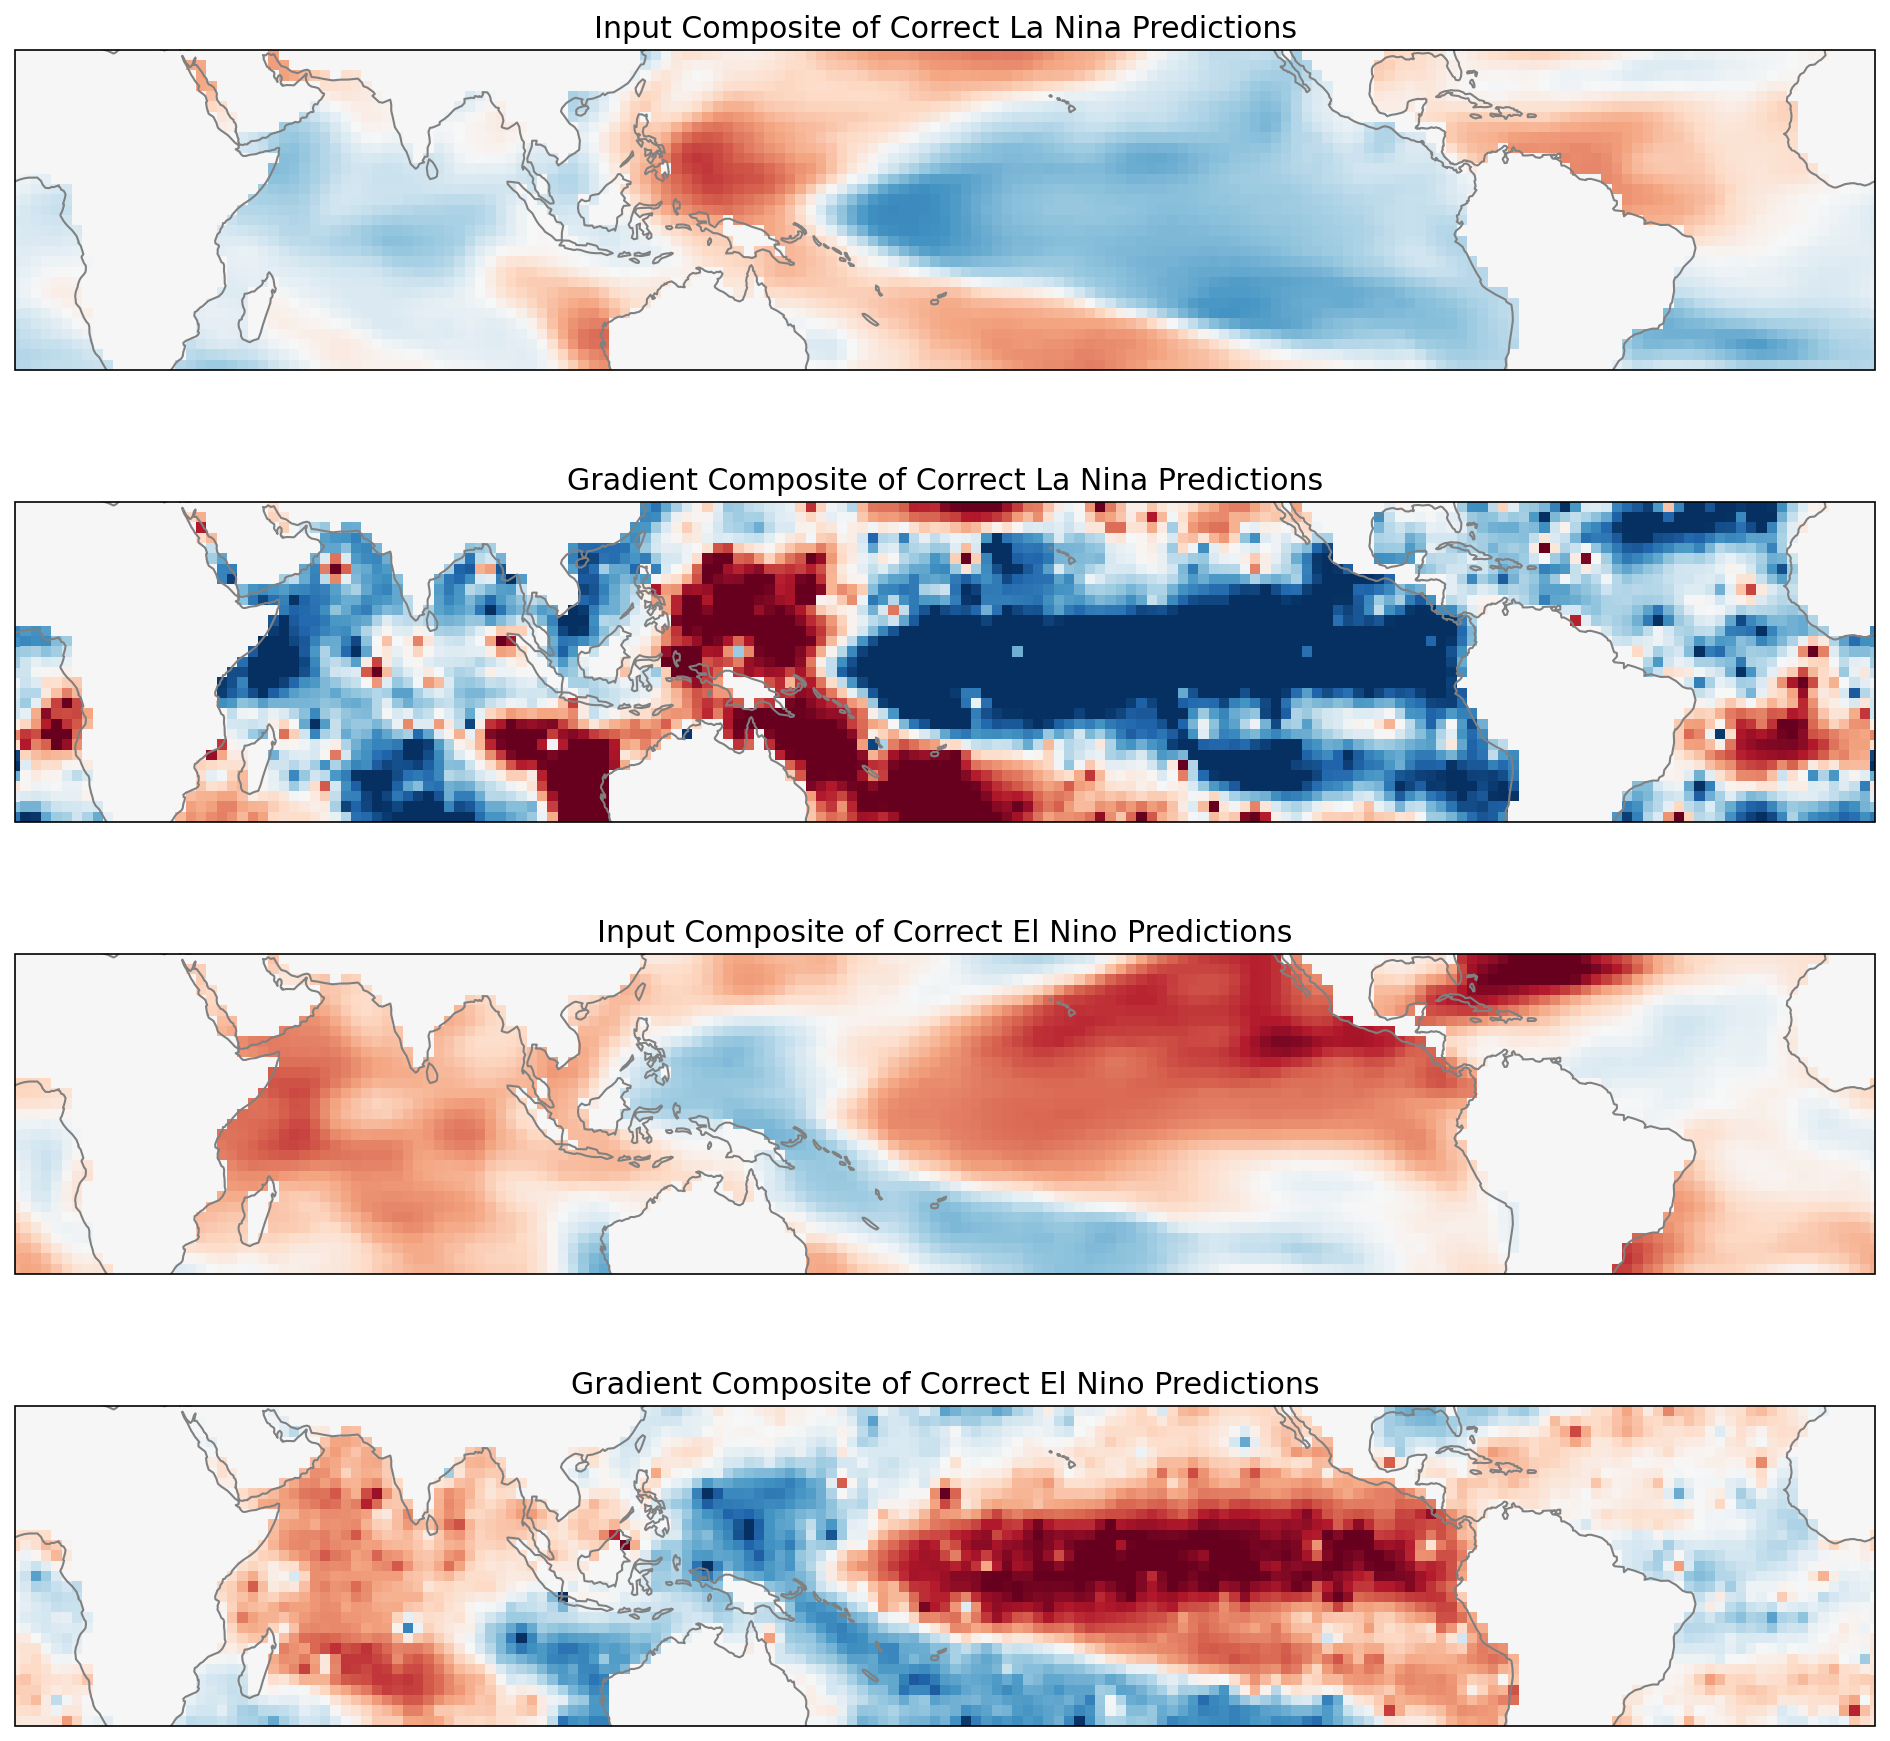

In [12]:
# ---- PLOT the "input" and the "gradient" ----
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

minval = -0.0001
maxval = 0.0001

plt.figure(figsize=(16,15))

ax1=plt.subplot(4,1,1,projection=projection)
ax1.pcolormesh(lon,lat,lanina_Input_mean,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input Composite of Correct La Nina Predictions')

ax1=plt.subplot(4,1,2,projection=projection)
ax1.pcolormesh(lon,lat,lanina_Grad_meanheatmap*(np.abs(sst[0,:,:].squeeze())>0),vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Gradient Composite of Correct La Nina Predictions')


ax1=plt.subplot(4,1,3,projection=projection)
ax1.pcolormesh(lon,lat,elnino_Input_mean,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input Composite of Correct El Nino Predictions')

ax1=plt.subplot(4,1,4,projection=projection)
ax1.pcolormesh(lon,lat,elnino_Grad_meanheatmap*(np.abs(sst[0,:,:].squeeze())>0)*1,vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Gradient Composite of Correct El Nino Predictions')

plt.show()

## Plot Input*Gradient

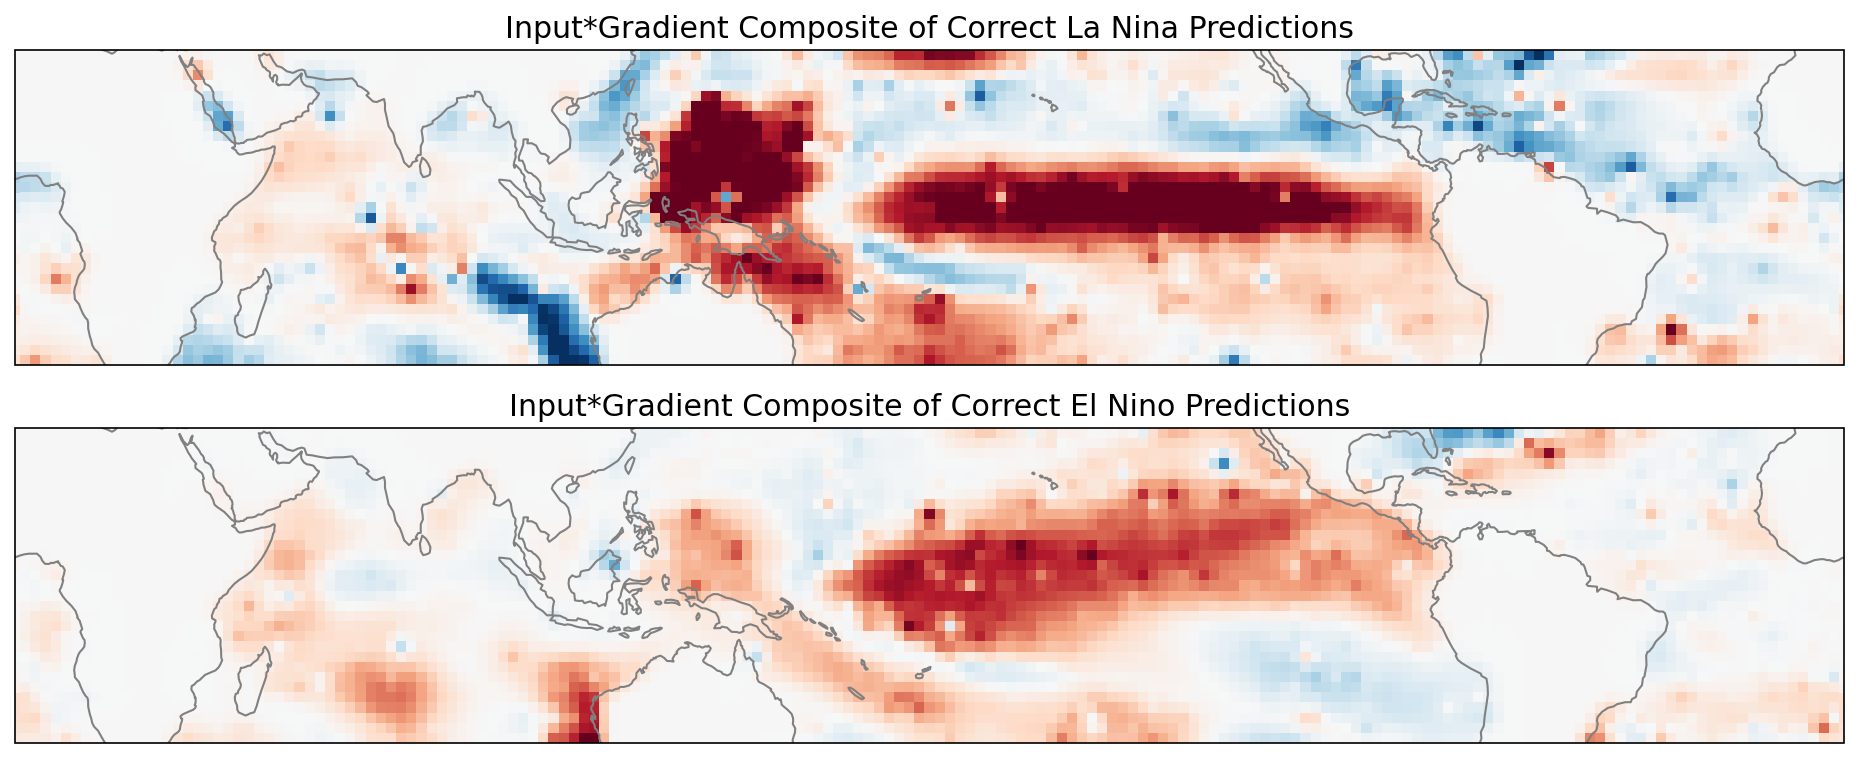

In [13]:
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

minval = -0.0001
maxval = 0.0001

plt.figure(figsize=(16,6))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,lanina_ItG_meanheatmap,vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input*Gradient Composite of Correct La Nina Predictions')

ax1=plt.subplot(2,1,2,projection=projection)
ax1.pcolormesh(lon,lat,elnino_ItG_meanheatmap,vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input*Gradient Composite of Correct El Nino Predictions')

plt.show()

# Is this what you expected?